In [2]:
import matplotlib.pyplot as plt
import numpy as np

def bsAsset(spot, sigma, r, T, nTimeSteps, G:np.array, theta=0):
    """Return samples from the 1-dimensional Black Scholes model

    Args:
        spot: 
        sigma:
        r:
        T:
        nTimeSteps:
        G: Either a vector of size nTimeSteps or a matrix of size (M, nTimeSteps) where M is the number of Monte Carlo samples
        theta: linear drift to add to the Brownian motion.

    """
    if isinstance(G, float):
        G = np.array([[G]])
    elif len(np.shape(G)) == 1:
        G = np.reshape(G, (1, np.size(G)))
    dt = T / nTimeSteps
    nSamples = np.shape(G)[0]
    S = spot * np.concatenate([np.ones((nSamples, 1)), np.cumprod(np.exp((r - sigma * sigma / 2) * dt + sigma * np.sqrt(dt) * (G + theta)), axis=1)], axis=1)
    return S

def payoffMax(S, strike):
    return np.maximum(np.max(S, axis=1) - strike * S[:, -1], 0)


In [3]:
spot = 100
K = 1.2
r = 0.02
sigma = 0.25
T = 2
nTimeSteps = 24
nSamples = 50000

## Crude Monte Carlo

In [7]:
def crudeMonteCarlo(N, spot, sigma, r, T, nTimeSteps, K):
    G = np.random.normal(0, 1, (N, nTimeSteps))
    S = bsAsset(spot, sigma, r, T, nTimeSteps, G)
    cashFlows = payoffMax(S, K) * np.exp(-r * T)
    price = np.mean(cashFlows)
    stdDev = np.sqrt(np.mean(cashFlows * cashFlows) - price * price)
    ciHalfWidth = 1.96 * stdDev / np.sqrt(N)
    return (price, ciHalfWidth)

(price, ciHalfWidth) = crudeMonteCarlo(nSamples, spot, sigma, r, T, nTimeSteps, K)
print(f'Crude Monte Carlo price {price} ± {ciHalfWidth}') 

Crude Monte Carlo price 11.485250881046015 ± 0.13127506623674345


## Antithetic variables

In [9]:
def antitheticMonteCarlo(N, spot, sigma, r, T, J, K):
    G = np.random.normal(0, 1, (N, J))
    S_plus = bsAsset(spot, sigma, r, T, J, G)
    S_minus = bsAsset(spot, sigma, r, T, J, -G)
    cashFlows_plus = payoffMax(S_plus, K) * np.exp(-r * T)
    cashFlows_minus = payoffMax(S_minus, K) * np.exp(-r * T)
    cashFlows = (cashFlows_minus + cashFlows_plus) / 2
    price = np.mean(cashFlows)
    stdDev = np.sqrt(np.mean(cashFlows * cashFlows) - price * price)
    ciHalfWidth = 1.96 * stdDev / np.sqrt(N)
    return (price, ciHalfWidth)

(price, ciHalfWidth) = antitheticMonteCarlo(int(nSamples / 2), spot, sigma, r, T, nTimeSteps, K)
print(f'Antithetic Monte Carlo price {price} ± {ciHalfWidth}')

Antithetic Monte Carlo price 11.482645218134515 ± 0.09282877025353095


## Control Variates

We use $S_T - S_O e^{r T}$ as a control variate.

In [6]:
from scipy.stats import norm

N = norm.cdf

def bsCall(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def bsPut(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)

def controlMonteCarlo(nSamples, spot, sigma, r, T, nTimeSteps, K):
    G = np.random.normal(0, 1, (nSamples, nTimeSteps))
    S = bsAsset(spot, sigma, r, T, nTimeSteps, G)
    controlVariate = np.maximum(S[:,-1] - K, 0) - bsCall(spot, K, T, r, sigma) * np.exp(r * T)
    cashFlowsWithControl = (payoffMax(S, K) + controlVariate) * np.exp(-r * T)
    price = np.mean(cashFlowsWithControl)
    stdDev = np.sqrt(np.mean(cashFlowsWithControl * cashFlowsWithControl) - price * price)
    ciHalfWidth = 1.96 * stdDev / np.sqrt(nSamples)
    return (price, ciHalfWidth)

def adaptiveControlMonteCarlo(nSamples, spot, sigma, r, T, nTimeSteps, K):
    G = np.random.normal(0, 1, (nSamples, nTimeSteps))
    S = bsAsset(spot, sigma, r, T, nTimeSteps, G)
    controlVariate = S[:, -1] - spot * np.exp(r *T) 
    payoffs = payoffMax(S, K)
    lambdaStar = np.mean(payoffs * controlVariate) / np.var(controlVariate)
    cashFlowsWithControl = (payoffs - lambdaStar * controlVariate) * np.exp(-r * T)
    price = np.mean(cashFlowsWithControl)
    stdDev = np.sqrt(np.mean(cashFlowsWithControl * cashFlowsWithControl) - price * price)
    ciHalfWidth = 1.96 * stdDev / np.sqrt(nSamples)
    return (price, ciHalfWidth, lambdaStar)


(price, ciHalfWidth) = controlMonteCarlo(nSamples, spot, sigma, r, T, nTimeSteps, K)
print(f'Control Variate Monte Carlo price {price} ± {ciHalfWidth}')
(price, ciHalfWidth, lambdaStar) = adaptiveControlMonteCarlo(nSamples, spot, sigma, r, T, nTimeSteps, K)
print(f'Adaptive Control Variate Monte Carlo price {price} ± {ciHalfWidth} with optimal parameter {lambdaStar}')

Control Variate Monte Carlo price 11.347416536595743 ± 0.2584273292707311
Adaptive Control Variate Monte Carlo price 11.484004959622677 ± 0.10131349323158424 with optimal parameter -0.26041027504729936


## Fonction d'importance pour le call

In [7]:
def payoffCall(S, strike):
    return np.maximum(S[:,-1] - strike, 0)

spot = 100
r = 0.03
sigma = 0.2
T = 2
K = 120
nTimeSteps = 1


In [8]:
def computeThetaN(spot, r, sigma, T, K, nSamples, gamma, beta):
    alpha = 1
    theta = np.empty(nSamples)
    theta[0] = 0
    for i in range(1, nSamples):
        G = np.random.normal()
        ST = bsAsset(spot, sigma, r, T, 1, G, theta[i-1])
        proposal = theta[i - 1] - gamma / (i + 500) ** beta * payoffCall(ST, K) ** 2 * (theta[i-1] - G) * np.exp(theta[i-1] ** 2 / 2 - theta[i-1] * G)
        if proposal**2 < np.log(alpha + 1):
            theta[i] = proposal.item()
        else:
            theta[i] = 0
            alpha += 1
    return theta

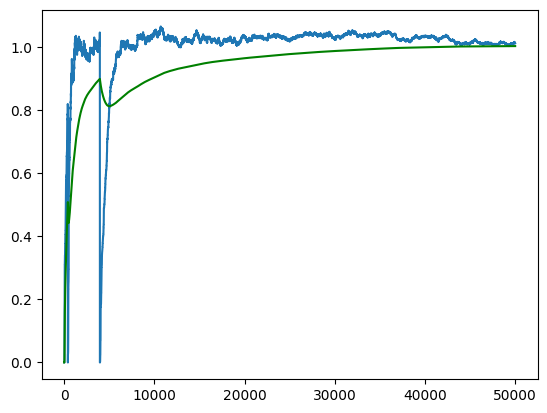

In [9]:
theta = computeThetaN(spot, r, sigma, T, K, 50000, 0.001, 0.75)
barTheta = np.cumsum(theta) / np.arange(1, np.size(theta) + 1)
plt.plot(theta)
plt.plot(barTheta, color='green')

In [12]:
def mcis(spot, sigma, r, T, K, nSamples, theta):
    G = np.random.normal(0, 1, (nSamples, 1))
    ST = bsAsset(spot, sigma, r, T, 1, G, theta)
    payoffs = np.exp(-r * T) * payoffCall(ST, K) * np.exp(-theta * np.squeeze(G) - theta ** 2 / 2)
    price = np.mean(payoffs)
    stdDev = np.sqrt(np.mean(payoffs * payoffs) - price ** 2)
    ciHalfWidth = 1.96 * stdDev / np.sqrt(nSamples)
    return (price, ciHalfWidth)

In [15]:
price, ci = mcis(spot, sigma, r, T, K, 50000, theta[-1])
print(f"Crude Monte Carlo: {price} ± {ci}")
price, ci = mcis(spot, sigma, r, T, K, 50000, barTheta[-1])
print(f"Crude Monte Carlo: {price} ± {ci}")
price, ci= mcis(spot, sigma, r, T, K, 50000, 0)
print(f"Crude Monte Carlo: {price} ± {ci}")

Crude Monte Carlo: 6.546843060243203 ± 0.04659539034704773
Crude Monte Carlo: 6.584580235236591 ± 0.046943764321244655
Crude Monte Carlo: 6.569105345018524 ± 0.13478958303030686
